# Task
    Locate a dataset containing both noisy and noise-free multiexponential decay curves using the provided link: 

    https://drive.google.com/file/d/11glr0L9CnnOfX5sG8zrzXyjJLWgQsUIL/view?usp=sharing. 

    Suggest simple and straightforward deep learning algorithm to perform supervised denoising of these curves. Choose a validation strategy for your selected method. Select and justify a metric to evaluate the model's performance. Save the denoised curves from the validation dataset as .csv files. Create a train/test demonstration in a Jupyter notebook with basic result visualization.

    The dataset includes files named, for example, “cor_36_5_0.csv”, “cor_36_5_1.csv”, “cor_36_5_2.csv”, etc., where “cor_36_5” serves as a file ID, and the number preceding '.csv' (ranging from 0 to 9) represents an arbitrary noise level. Consequently, the file names ending in “0.csv” are considered noise-free targets.

In [624]:
import os
import yaml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.model_selection import train_test_split
from skimage.metrics import structural_similarity as ssim
from torch import nn
from torch.utils.data import TensorDataset, DataLoader

from utils.utils import set_random_seed


with open('config.yaml') as yf:
    config = yaml.safe_load(yf)

set_random_seed(config['SEED'])

In [603]:
noise_free_csv = [path for path in os.listdir('data') if path.endswith('_0.csv')]
print('Number of unique signals: ', len(noise_free_csv))

noise_free_dfs = [pd.read_csv('data/' + path, header=None) for path in noise_free_csv]
noise_free_dfs = pd.concat(noise_free_dfs, axis=1)
noise_free_dfs.columns = [str(i) for i in range(len(noise_free_dfs.columns))]
noise_free_dfs = noise_free_dfs.T
print('Unique signals dataframe:')
display(noise_free_dfs)
print('Number duplicated signals: ', noise_free_dfs.duplicated().sum())
print('Lets take a look at the duplicated signals:')
display(noise_free_dfs.loc[noise_free_dfs.duplicated()])
print('Duplicated signals are just a copy of the empty signal')

Number of unique signals:  500
Unique signals dataframe:


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.764656,0.764454,0.764253,0.764052,0.763650,0.763248,0.762848,0.762448,0.761650,0.760854,...,3.586878e-04,2.949418e-04,2.406477e-04,1.951803e-04,1.582533e-04,1.278327e-04,1.029769e-04,8.279047e-05,6.603261e-05,4.860533e-05
2,0.427243,0.426833,0.426423,0.426014,0.425200,0.424390,0.423583,0.422780,0.421184,0.419603,...,8.838610e-07,6.508686e-07,4.691275e-07,3.312764e-07,2.310042e-07,1.579188e-07,1.058585e-07,6.958483e-08,4.425297e-08,2.325709e-08
3,0.664228,0.661950,0.659723,0.657545,0.653326,0.649276,0.645380,0.641626,0.634500,0.627822,...,4.958751e-04,4.076334e-04,3.323231e-04,2.692136e-04,2.179936e-04,1.758816e-04,1.415816e-04,1.138412e-04,9.092749e-05,6.725288e-05
4,0.576467,0.557861,0.541632,0.527236,0.502551,0.481875,0.464101,0.448530,0.422265,0.400696,...,6.462117e-06,5.594778e-06,4.822575e-06,4.144499e-06,3.565690e-06,3.063538e-06,2.630458e-06,2.258443e-06,1.930916e-06,1.565035e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
496,0.623152,0.622702,0.622254,0.621808,0.620923,0.620045,0.619174,0.618310,0.616604,0.614924,...,5.915820e-04,5.100071e-04,4.373950e-04,3.737275e-04,3.195291e-04,2.726948e-04,2.325112e-04,1.982106e-04,1.682359e-04,1.350834e-04
497,0.078995,0.078977,0.078958,0.078939,0.078902,0.078865,0.078828,0.078791,0.078717,0.078643,...,1.143519e-04,9.841182e-05,8.423256e-05,7.180975e-05,6.124441e-05,5.212473e-05,4.431043e-05,3.765061e-05,3.184153e-05,2.543315e-05
498,0.691460,0.678865,0.667214,0.656355,0.636582,0.618893,0.602858,0.588178,0.562054,0.539298,...,2.741718e-06,2.328905e-06,1.967537e-06,1.655933e-06,1.395009e-06,1.173152e-06,9.858086e-07,8.283583e-07,6.928380e-07,5.454575e-07


Number duplicated signals:  99
Lets take a look at the duplicated signals:


,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
480,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
485,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Duplicated signals are just a copy of the empty signal


So we do not have any data duplication, so we can be free of the problem of data leakage to dev dataset.

To prepare proper validation split, let's try to cluster our ground truth signals. Firstly, in such way we can see what type of signals we have, and secondly we can use this clusters to perform stratify validation split to be sure that train and dev datasets have same data distribution.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:

0.568 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.3s finished


0.218 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.3s finished


0.214 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.2s finished


0.213 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.3s finished


0.212 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.2s finished


0.211 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.3s finished


0.211 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.3s finished


0.211 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.4s finished


0.211 --> 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.5s finished


0.211 --> 


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:    1.4s finished


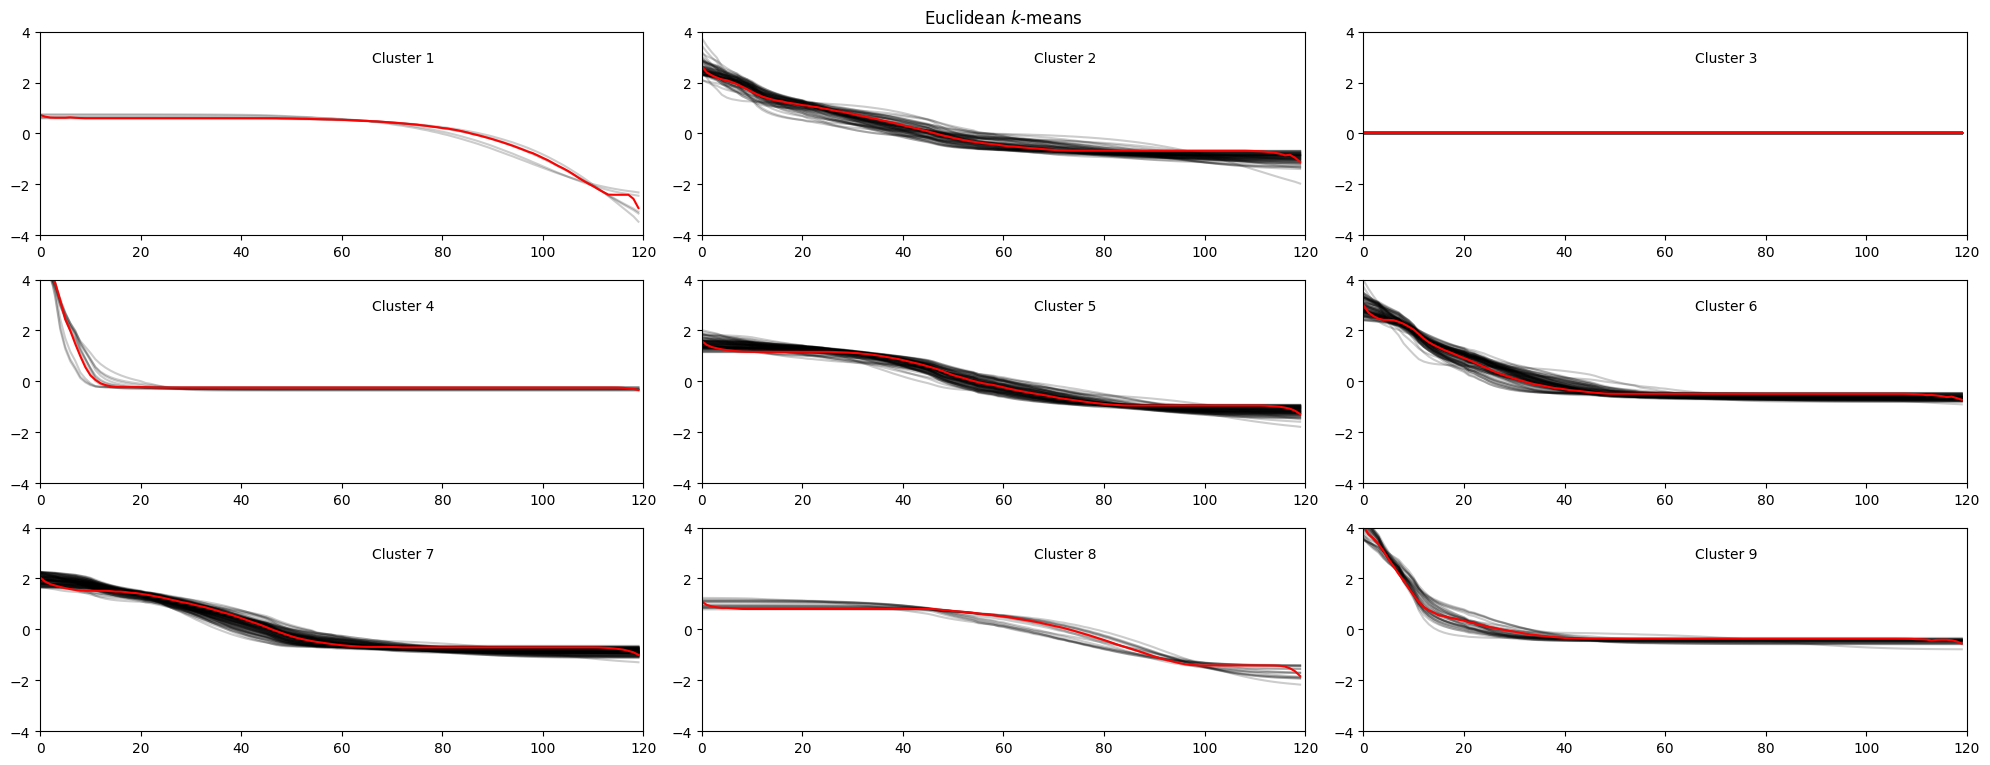

In [113]:
n_clusters = 9
km = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", max_iter=10, random_state=config['SEED'], verbose=True, n_jobs=-1)
X_train = TimeSeriesScalerMeanVariance().fit_transform(noise_free_dfs)
y_pred_km = km.fit_predict(X_train)

plt.figure(figsize=(20, 10))
for yi in range(n_clusters):
    plt.subplot(n_clusters // 3 + 1, 3, yi + 1)
    for xx in X_train[y_pred_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_train.shape[1])
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Euclidean $k$-means")

plt.tight_layout()
plt.show()

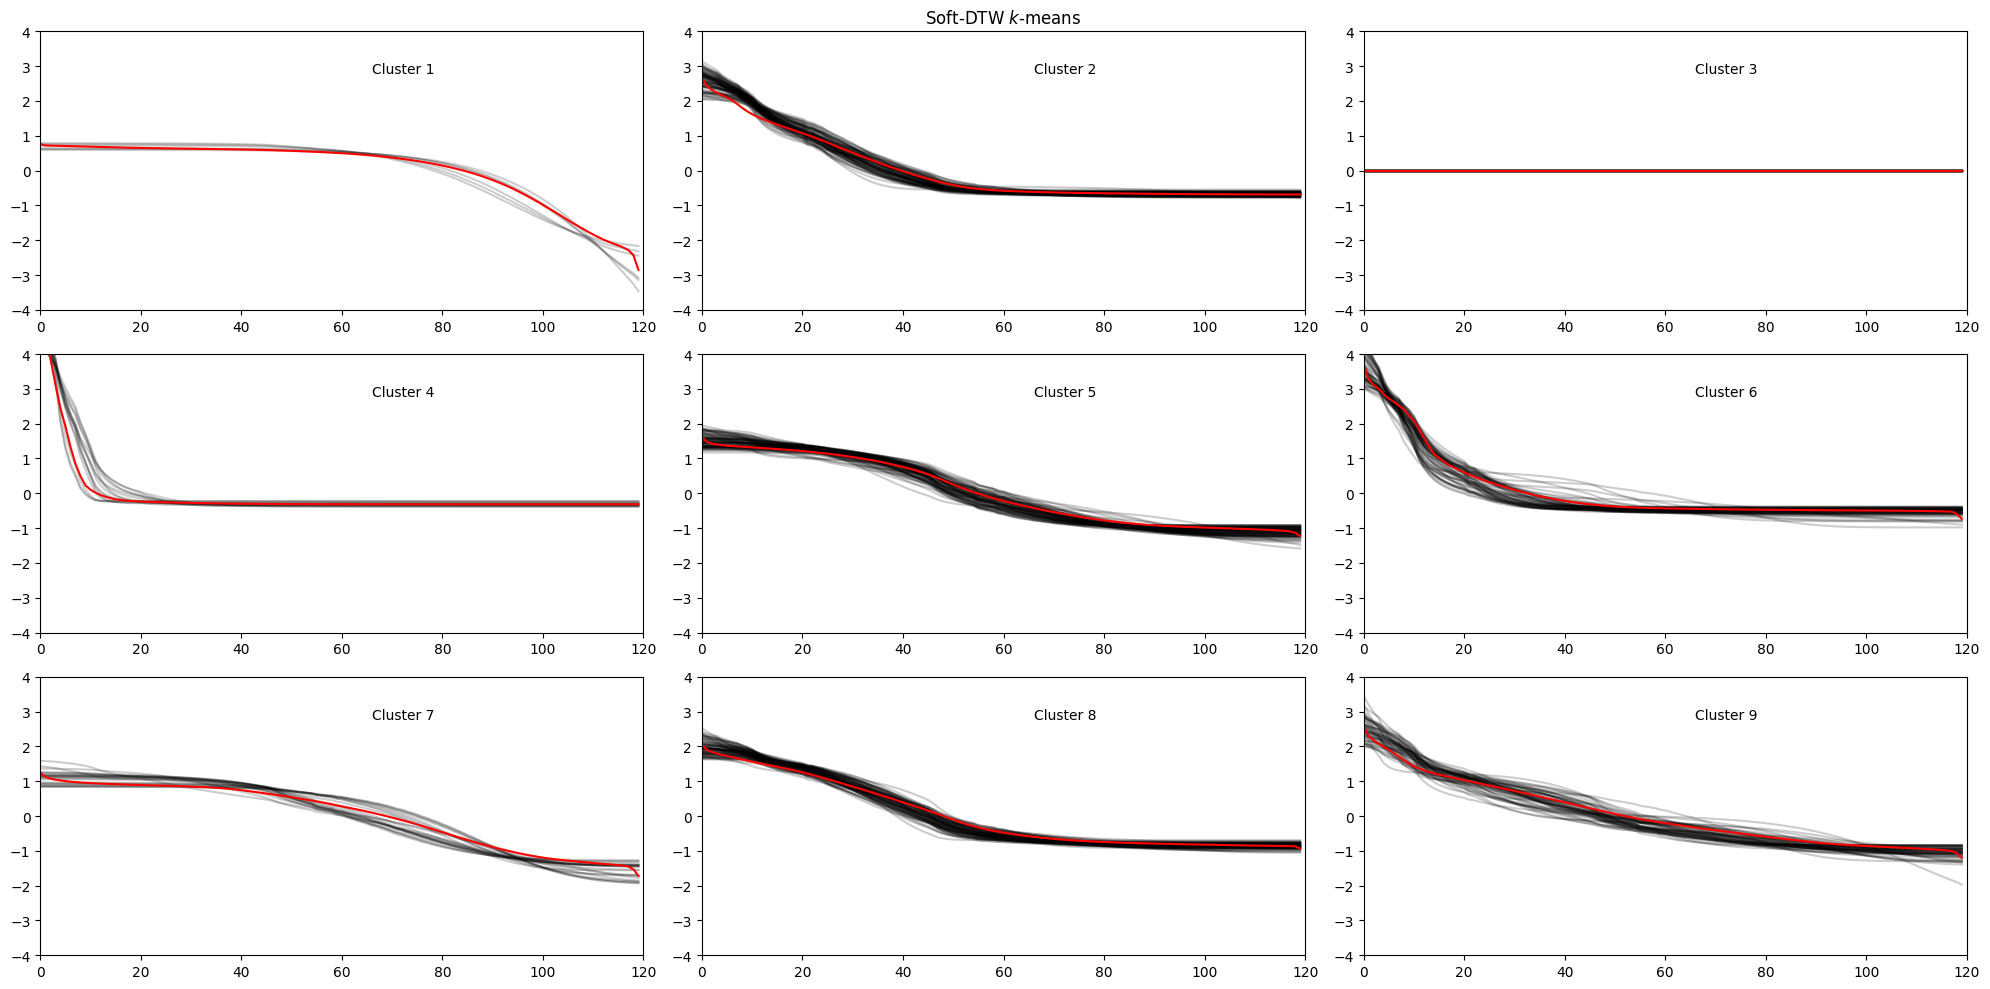

In [122]:
n_clusters = 9
sdtw_km = TimeSeriesKMeans(n_clusters=n_clusters,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True,
                           n_jobs=-1,
                           random_state=config['SEED'])
y_pred_sdtw_km = sdtw_km.fit_predict(X_train)

plt.figure(figsize=(20, 10))
for yi in range(n_clusters):
    plt.subplot(n_clusters // 3, 3, yi + 1)
    for xx in X_train[y_pred_sdtw_km == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, X_train.shape[1])
    plt.ylim(-4, 4)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)
    if yi == 1:
        plt.title("Soft-DTW $k$-means")

plt.tight_layout()
plt.show()

After my short investigation, we can see about 8 types of signals, so lets perform validation split.

In [689]:
train_csv, valid_csv = train_test_split(noise_free_csv, test_size=0.15, random_state=config['SEED'], stratify=y_pred_sdtw_km)
train_csv = [el[:-6] for el in train_csv]
valid_csv = [el[:-6] for el in valid_csv]

print('Train csv: ', len(train_csv))
print('Valid csv: ', len(valid_csv))

# prepare pairs of noise signal and noise-free signal
train_x, train_y = [], []
for patter in train_csv:
    target = pd.read_csv(os.path.join('data', patter + '_0.csv'), header=None)[0].tolist()
    csv_files = [el for el in os.listdir('data') if el.startswith(patter) and not el.endswith('_0.csv')]
    for fl in csv_files:
        tmp = pd.read_csv(os.path.join('data', fl), header=None)[0].tolist()
        train_x.append(tmp)
        train_y.append(target)
        
valid_x, valid_y, valid_file_names = [], [], []
for patter in valid_csv:
    target = pd.read_csv(os.path.join('data', patter + '_0.csv'), header=None)[0].tolist()
    csv_files = [el for el in os.listdir('data') if el.startswith(patter) and not el.endswith('_0.csv')]
    for fl in csv_files:
        tmp = pd.read_csv(os.path.join('data', fl), header=None)[0].tolist()
        valid_x.append(tmp)
        valid_y.append(target)
        valid_file_names.append(fl)
        
# shuffle data to avoid overfitting from the same pattern
indexes = np.random.permutation(range(len(train_x)))
train_x = np.array(train_x)[indexes]
train_y = np.array(train_y)[indexes]
        
print('Train: ', len(train_x))
print('Valid: ', len(valid_x)) 

Train csv:  425
Valid csv:  75
Train:  3825
Valid:  675


Let's define baseline of denoising signal with smoothing and also define evaluation metric.

In [693]:
def normalized_cross_correlation(signal1, signal2):
    signal1 = np.array(signal1)
    signal2 = np.array(signal2)
    signal1_normalized = (signal1 - np.mean(signal1)) / np.std(signal1)
    if signal2.sum() != 0:
        signal2_normalized = (signal2 - np.mean(signal2)) / np.std(signal2)
    else:
        signal2_normalized = signal2

    ncc = np.sum((signal1_normalized * signal2_normalized)) / len(signal1)
    return ncc


def structural_similarity_index(signal1, signal2):
    signal1 = np.array(signal1)
    signal2 = np.array(signal2)
    signal1 = (signal1 - np.min(signal1)) / (np.max(signal1) - np.min(signal1))
    if signal2.sum() != 0:
        signal2 = (signal2 - np.min(signal2)) / (np.max(signal2) - np.min(signal2))

    ssim_value, _ = ssim(signal1, signal2, full=True, data_range=signal2.max() - signal2.min())
    return ssim_value


def mean_absolute_error(signal1, signal2):
    mae = np.mean(np.abs(signal1 - signal2))
    return mae

In [695]:
window_size = 7
valid_x_smoothed = [np.convolve(signal, np.ones(window_size)/window_size, mode='same') for signal in valid_x]

cross_corr_eval = ([normalized_cross_correlation(x,y) for x, y in zip(valid_x_smoothed, valid_y)])
ssi_eval = ([structural_similarity_index(x,y) for x, y in zip(valid_x_smoothed, valid_y)])
mae_eval = ([mean_absolute_error(x,y) for x, y in zip(valid_x_smoothed, valid_y)])

print('Cross correlation: ', cross_corr_eval)
print('SSI: ', ssi_eval)
print('MAE: ', mae_eval)


print('Cross correlation: ', np.mean(cross_corr_eval))
print('SSI: ', np.mean(ssi_eval))
print('MAE: ', np.mean(mae_eval))

Cross correlation:  [0.9918522430977806, 0.9925206459350616, 0.992761307336702, 0.9924623736217134, 0.9899914689246264, 0.9903467840407026, 0.9902360560711212, 0.990084916470926, 0.9900601391427326, 0.9715970791656086, 0.9706389298488044, 0.9674911176156971, 0.9692744537988519, 0.9690856436369185, 0.9579645628766875, 0.9680406082380342, 0.9661885501403592, 0.9366123582600341, 0.9874072921171829, 0.9867570642266976, 0.9890047901037174, 0.9885621296147848, 0.9842480439806057, 0.9851168542806318, 0.9788583119475903, 0.985660760795776, 0.9820603262598105, 0.9838234014004852, 0.9843721072463345, 0.9857563300823593, 0.9840550105168919, 0.9799721390664479, 0.98446671946917, 0.9822194141651827, 0.9800469663006905, 0.9808528001480883, 0.9891988571444039, 0.9883921532696086, 0.9891790545528932, 0.9868854294302303, 0.9886322943447499, 0.9872543438618495, 0.9884125731195603, 0.9849882458599107, 0.9856159279863682, 0.9885978818094782, 0.9882028293404671, 0.9898129478585534, 0.9883431207433302, 0.98

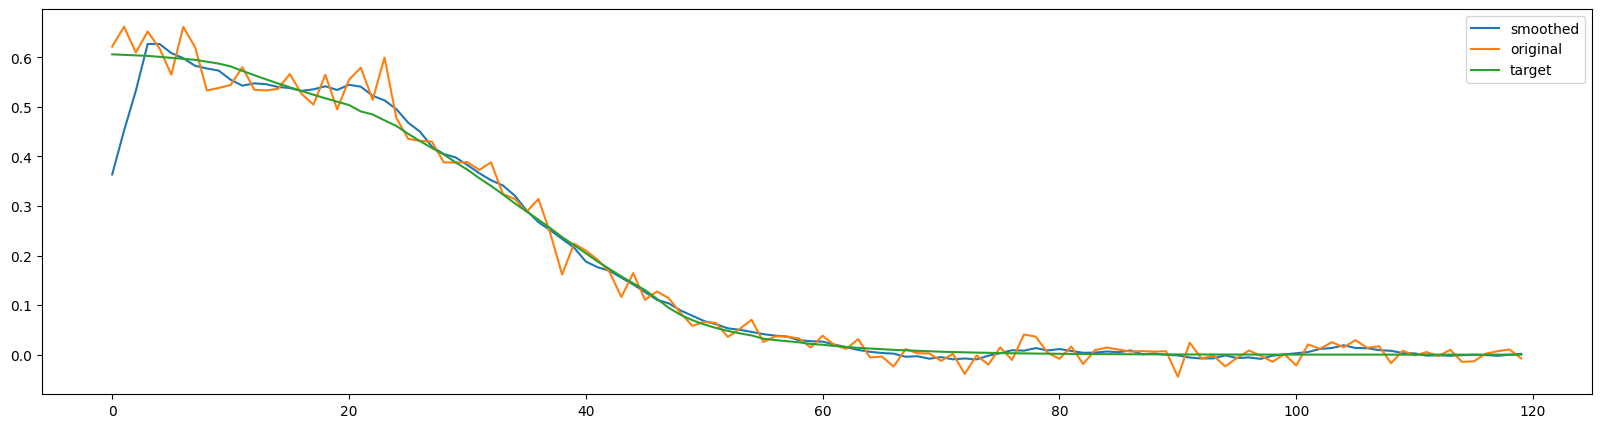

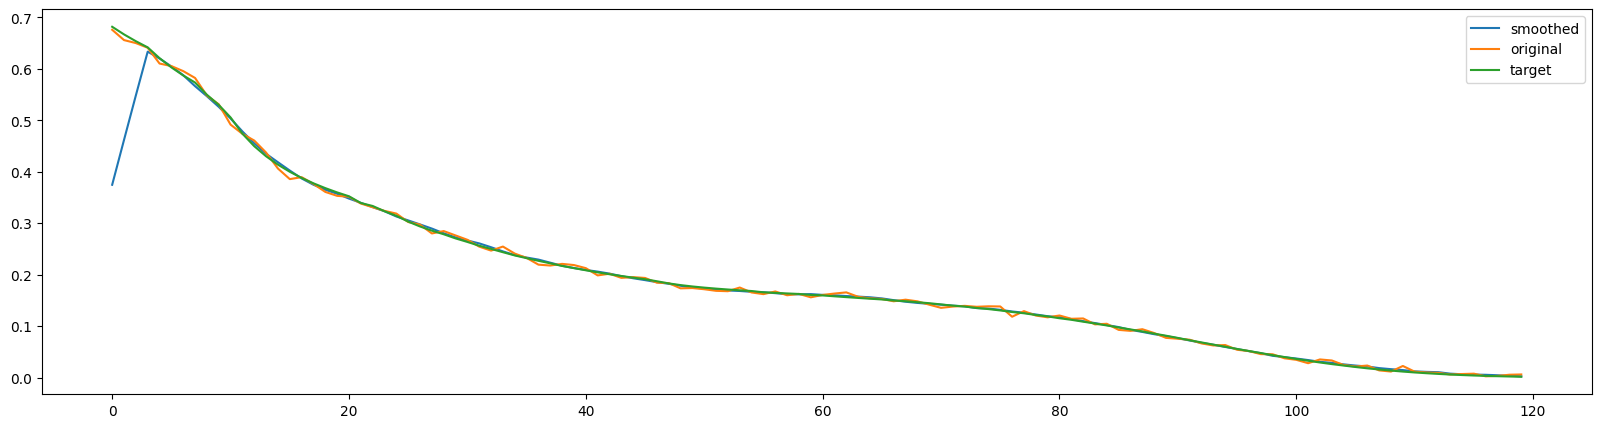

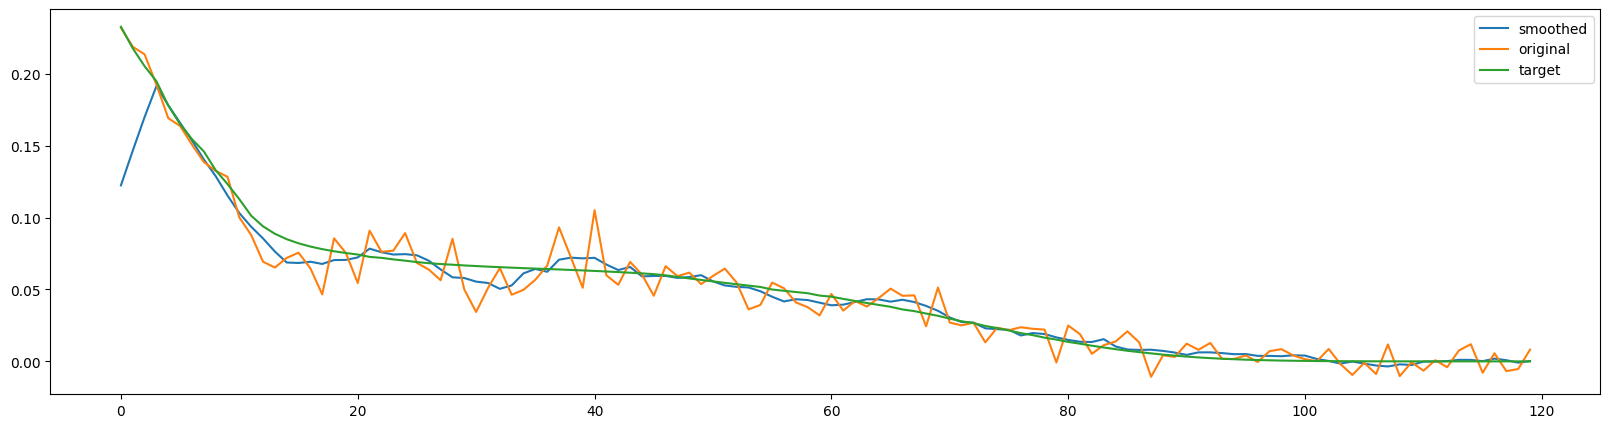

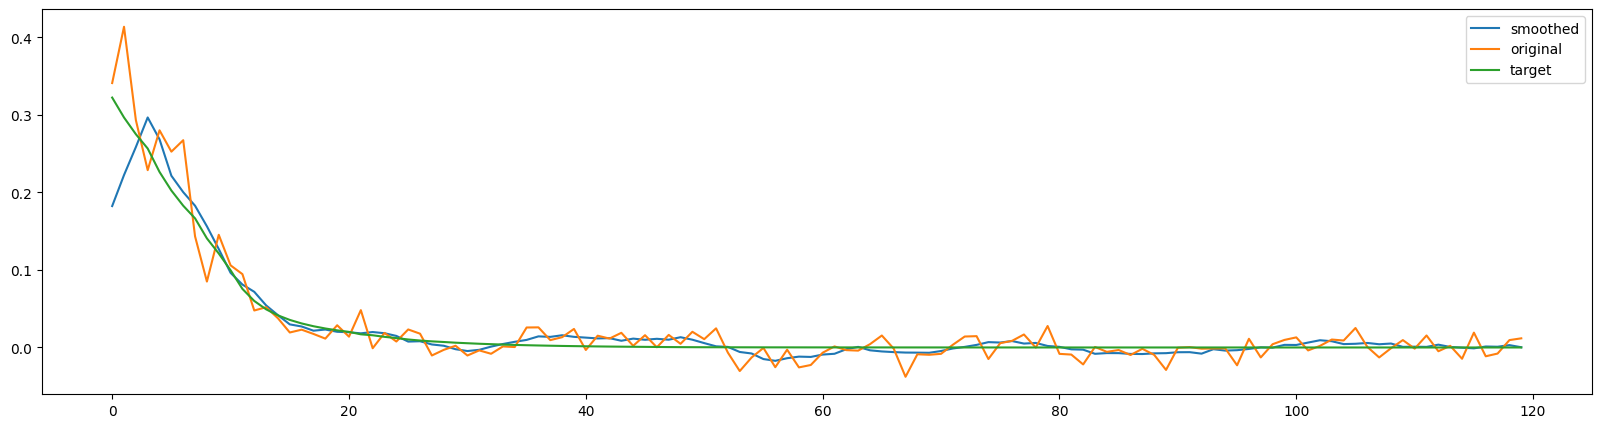

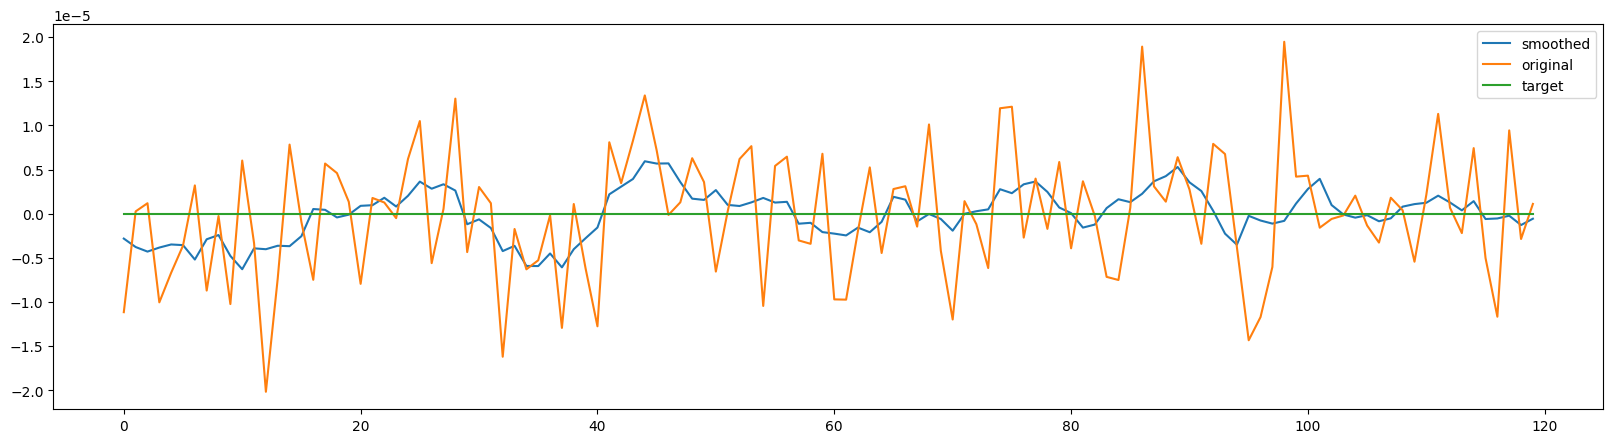

In [697]:
indexes = np.random.choice(range(len(valid_x_smoothed)), 5)
for i in indexes:
    plt.figure(figsize=(20, 5))
    plt.plot(valid_x_smoothed[i], label='smoothed')
    plt.plot(valid_x[i], label='original')
    plt.plot(valid_y[i], label='target')
    plt.legend()
    plt.show()

For evaluating baseline smoothing approach I choose 3 metrics. NCC and SSI calculate similarity of two signals, where 1 is complite similarity, but we can see not safficiant work on ground truth empty sigmal, here we are receiving zero value of similary, while smoothing in reality give some improvement. It says, that this metrics can be used for evaluation but not for training. As third one I chose MAE, as when dealing with noise, it is very little mismatching and we'd like to panish model on small errors rather then on big outliers as with MSE.

As far as sollution is preferable to be simple and straightforward we can build light autoencoder model with 2 depth and use 1d convolution to detect patterns in signal better.

Evaluation metric: MAE.
Model Architecuter: 1d convolutional autoencoder

In [627]:
class DenoisingCNN(nn.Module):
    def __init__(self):
        super(DenoisingCNN, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
        )
        self.decoder = nn.Sequential(
            nn.Conv1d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False),
            nn.Conv1d(16, 1, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='linear', align_corners=False)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Epoch [1/25], Loss: 0.0624, Valid Loss: 0.0175
Epoch [2/25], Loss: 0.0080, Valid Loss: 0.0052
Epoch [3/25], Loss: 0.0050, Valid Loss: 0.0049
Epoch [4/25], Loss: 0.0043, Valid Loss: 0.0045
Epoch [5/25], Loss: 0.0040, Valid Loss: 0.0037
Epoch [6/25], Loss: 0.0037, Valid Loss: 0.0036
Epoch [7/25], Loss: 0.0038, Valid Loss: 0.0035
Epoch [8/25], Loss: 0.0036, Valid Loss: 0.0039
Epoch [9/25], Loss: 0.0036, Valid Loss: 0.0035
Epoch [10/25], Loss: 0.0036, Valid Loss: 0.0037
Epoch [11/25], Loss: 0.0037, Valid Loss: 0.0035
Epoch [12/25], Loss: 0.0037, Valid Loss: 0.0036
Epoch [13/25], Loss: 0.0036, Valid Loss: 0.0034
Epoch [14/25], Loss: 0.0035, Valid Loss: 0.0036
Epoch [15/25], Loss: 0.0035, Valid Loss: 0.0036
Epoch [16/25], Loss: 0.0035, Valid Loss: 0.0038
Epoch [17/25], Loss: 0.0035, Valid Loss: 0.0034
Epoch [18/25], Loss: 0.0036, Valid Loss: 0.0035
Epoch [19/25], Loss: 0.0035, Valid Loss: 0.0034
Epoch [20/25], Loss: 0.0034, Valid Loss: 0.0036
Epoch [21/25], Loss: 0.0036, Valid Loss: 0.0037
E

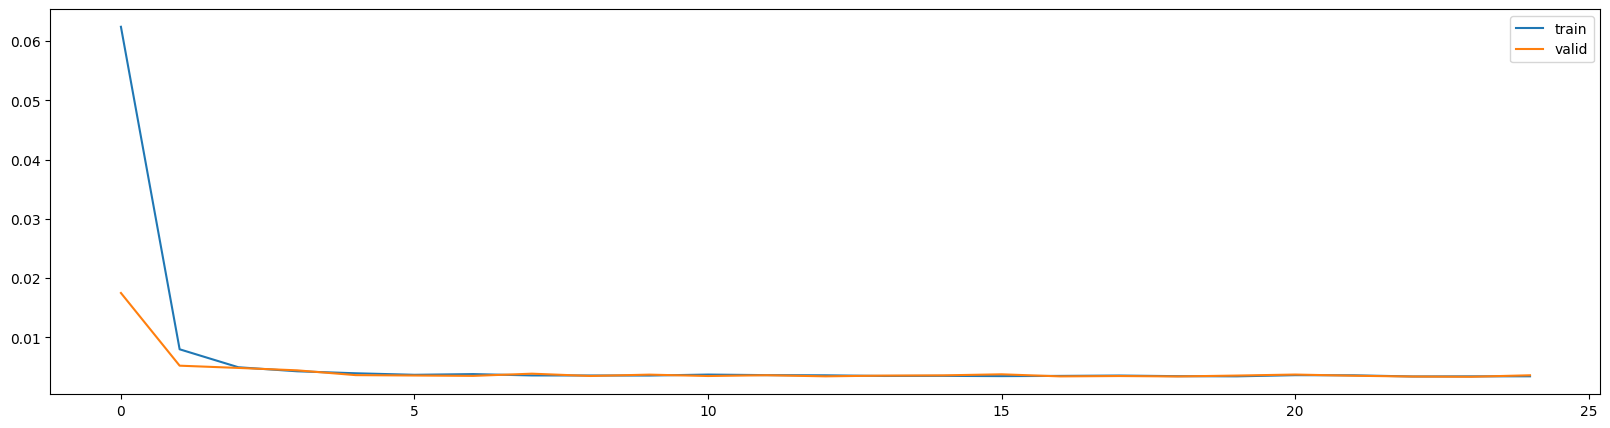

In [629]:
# BUG run twicely to reproduce results
train_dataset = TensorDataset(torch.tensor(train_x), torch.tensor(train_y))
valid_dataset = TensorDataset(torch.tensor(valid_x), torch.tensor(valid_y))
train_loader = DataLoader(train_dataset, batch_size=config['BATCH_SIZE'], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['BATCH_SIZE'], shuffle=False)

model = DenoisingCNN()
model.to('cuda:0')
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = config['EPOCHS']
train_losses, valid_losses = [], []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch in train_loader:
        X_train, y_train = batch
        X_train = torch.unsqueeze(X_train, 1)
        y_train = torch.unsqueeze(y_train, 1)
        X_train = X_train.to('cuda:0').to(torch.float32)
        y_train = y_train.to('cuda:0').to(torch.float32)

        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.detach().cpu().item()

    with torch.no_grad():
        model.eval()
        valid_loss = 0
        for batch in valid_loader:
            X_valid, y_valid = batch
            
            X_valid = torch.unsqueeze(X_valid, 1)
            y_valid = torch.unsqueeze(y_valid, 1)
            X_valid = X_valid.to('cuda:0').to(torch.float32)
            y_valid = y_valid.to('cuda:0').to(torch.float32)

            outputs = model(X_valid)
            loss = criterion(outputs, y_valid)
            valid_loss += loss.item()
    
    train_loss = train_loss / len(train_loader)
    valid_loss = valid_loss / len(valid_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')

plt.figure(figsize=(20, 5))
plt.plot(train_losses, label='train')
plt.plot(valid_losses, label='valid')
plt.legend()
plt.show()

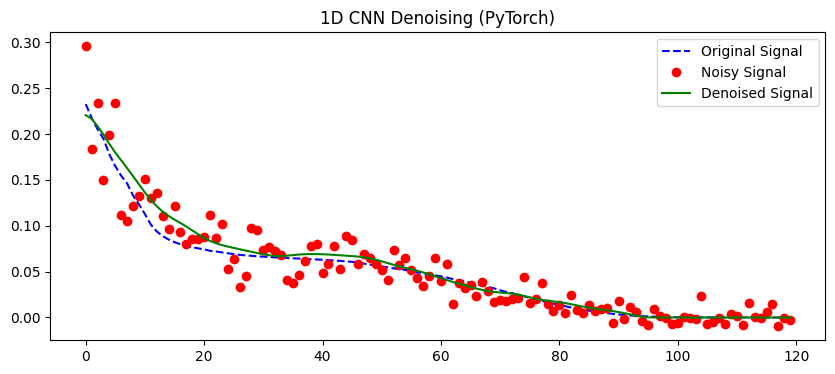

In [630]:
show_sample_x = valid_x[14]
show_sample_y = valid_y[14]
show_sample_x = torch.unsqueeze(torch.unsqueeze(torch.tensor(show_sample_x), 0), 0)

show_sample_y_hat = model(show_sample_x.to('cuda:0').to(torch.float32)).squeeze()

plt.figure(figsize=(10, 4))
plt.plot(show_sample_y, label='Original Signal', linestyle='--', color='blue')
plt.plot(show_sample_x.squeeze().numpy(), label='Noisy Signal', marker='o', linestyle='None', color='red')
plt.plot(show_sample_y_hat.detach().cpu().numpy(), label='Denoised Signal', linestyle='-', color='green')
plt.legend()
plt.title('1D CNN Denoising (PyTorch)')
plt.show()

In [656]:
valid_results = []
model.eval()
with torch.no_grad():
    for batch in valid_loader:
        X_valid, y_valid = batch
        X_valid = torch.unsqueeze(X_valid, 1)
        y_valid = torch.unsqueeze(y_valid, 1)
        X_valid = X_valid.to('cuda:0').to(torch.float32)
        y_valid = y_valid.to('cuda:0').to(torch.float32)

        outputs = model(X_valid).squeeze().cpu().numpy()
        valid_results.extend(outputs)

valid_results = pd.DataFrame(valid_results, index=valid_file_names)
display(valid_results)
valid_results.to_csv('denoising_valid_results.csv')

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
cor_30_4_1.csv,0.661495,0.661281,0.660854,0.659410,0.656951,0.657615,0.661402,0.663117,0.662760,0.660568,...,0.005095,0.004114,0.002939,0.001764,0.000588,0.000165,0.000495,0.000495,0.000165,0.0
cor_30_4_2.csv,0.669777,0.668721,0.666609,0.663039,0.658013,0.656668,0.659002,0.659477,0.658094,0.654590,...,0.001469,0.000708,0.000236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cor_30_4_3.csv,0.682114,0.680501,0.677275,0.672543,0.666305,0.663655,0.664595,0.663673,0.660890,0.656716,...,0.000227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cor_30_4_4.csv,0.685169,0.682975,0.678589,0.672649,0.665155,0.661351,0.661236,0.659624,0.656516,0.652998,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cor_30_4_5.csv,0.637183,0.637112,0.636970,0.636557,0.635874,0.637969,0.642842,0.645388,0.645608,0.644329,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cor_61_1_5.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cor_61_1_6.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cor_61_1_7.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
cor_61_1_8.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Model analysis

In [664]:
valid_target_file_names = [el[:-6] + '_0.csv'  for el in valid_file_names]
valid_target_results = pd.DataFrame([pd.read_csv(os.path.join('data', path), header=None)[0].tolist() for path in valid_target_file_names], index=valid_file_names)
valid_target_results

,0,1,2,3,4,5,6,7,8,9,...,110,111,112,113,114,115,116,117,118,119
cor_30_4_1.csv,0.655728,0.655557,0.655386,0.655215,0.654874,0.654534,0.654194,0.653855,0.653179,0.652506,...,0.003242,0.002776,0.00236,0.001996,0.001687,0.001421,0.001194,0.001001,0.000835,0.000653
cor_30_4_2.csv,0.655728,0.655557,0.655386,0.655215,0.654874,0.654534,0.654194,0.653855,0.653179,0.652506,...,0.003242,0.002776,0.00236,0.001996,0.001687,0.001421,0.001194,0.001001,0.000835,0.000653
cor_30_4_3.csv,0.655728,0.655557,0.655386,0.655215,0.654874,0.654534,0.654194,0.653855,0.653179,0.652506,...,0.003242,0.002776,0.00236,0.001996,0.001687,0.001421,0.001194,0.001001,0.000835,0.000653
cor_30_4_4.csv,0.655728,0.655557,0.655386,0.655215,0.654874,0.654534,0.654194,0.653855,0.653179,0.652506,...,0.003242,0.002776,0.00236,0.001996,0.001687,0.001421,0.001194,0.001001,0.000835,0.000653
cor_30_4_5.csv,0.655728,0.655557,0.655386,0.655215,0.654874,0.654534,0.654194,0.653855,0.653179,0.652506,...,0.003242,0.002776,0.00236,0.001996,0.001687,0.001421,0.001194,0.001001,0.000835,0.000653
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
cor_61_1_5.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cor_61_1_6.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cor_61_1_7.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
cor_61_1_8.csv,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
window_size = 7
valid_x_smoothed = [np.convolve(signal, np.ones(window_size)/window_size, mode='same') for signal in valid_x]

cross_corr_eval = ([normalized_cross_correlation(x,y) for x, y in zip(valid_x_smoothed, train_y)])
ssi_eval = ([structural_similarity_index(x,y) for x, y in zip(valid_x_smoothed, train_y)])
mae_eval = ([mean_absolute_error(x,y) for x, y in zip(valid_x_smoothed, train_y)])

print('Cross correlation: ', np.mean(cross_corr_eval))
print('SSI: ', np.mean(ssi_eval))
print('MAE: ', np.mean(mae_eval))

In [681]:
mae_erros = []
for target, res in zip(valid_target_results.iterrows(), valid_results.iterrows()):
    mae_erros.append(mean_absolute_error(target[1], res[1]))
analyse_df = pd.DataFrame(mae_erros, index=valid_target_results.index, columns=['MAE'])
analyse_df['noise_level'] = [el.split('.')[0].split('_')[3] for el in analyse_df.index]
analyse_df

,MAE,noise_level
cor_30_4_1.csv,0.003051,1
cor_30_4_2.csv,0.004379,2
cor_30_4_3.csv,0.004646,3
cor_30_4_4.csv,0.006145,4
cor_30_4_5.csv,0.006255,5
...,...,...
cor_61_1_5.csv,0.000000,5
cor_61_1_6.csv,0.000000,6
cor_61_1_7.csv,0.000000,7
cor_61_1_8.csv,0.000000,8


In [685]:
analyse_df. groupby('noise_level').mean()

,MAE
noise_level,
1,0.002060
2,0.002255
3,0.002565
4,0.003131
5,0.003421
6,0.004052
7,0.004441
8,0.004828
9,0.005835


In [684]:
analyse_df.sort_values(by='MAE', ascending=False).head(25)

,MAE,noise_level
cor_55_5_9.csv,0.017593,9
cor_15_5_8.csv,0.016083,8
cor_30_4_9.csv,0.014090,9
cor_15_5_9.csv,0.013230,9
cor_3_2_9.csv,0.013098,9
cor_72_5_9.csv,0.012701,9
cor_70_5_8.csv,0.012242,8
cor_73_3_7.csv,0.012118,7
cor_59_5_6.csv,0.011533,6
cor_3_2_8.csv,0.011137,8


With NN we received twice better results on MAE metrics compare to baseline. Prety clear, but error rate grows as we processing more noised data, and samples with biggest error is 8-9 noise level. Let's look on some of this examples and try out to find some patterns to improve model performance.

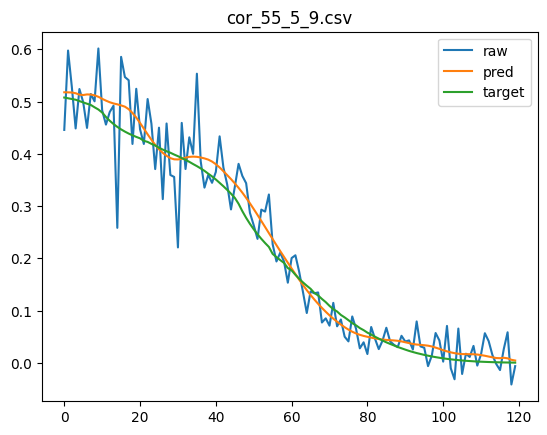

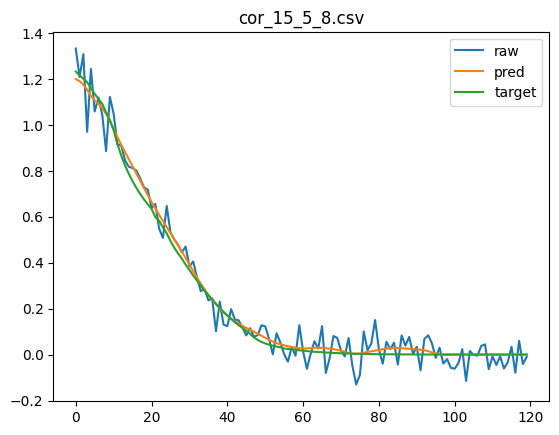

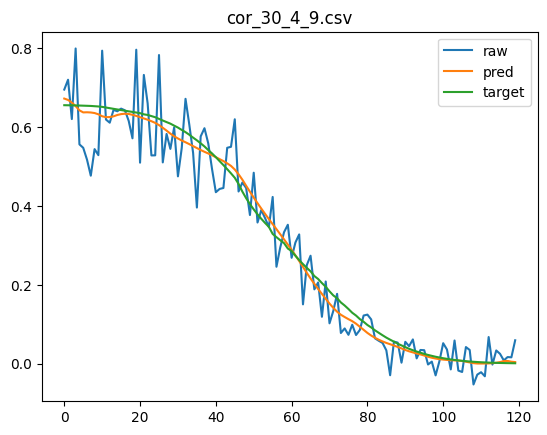

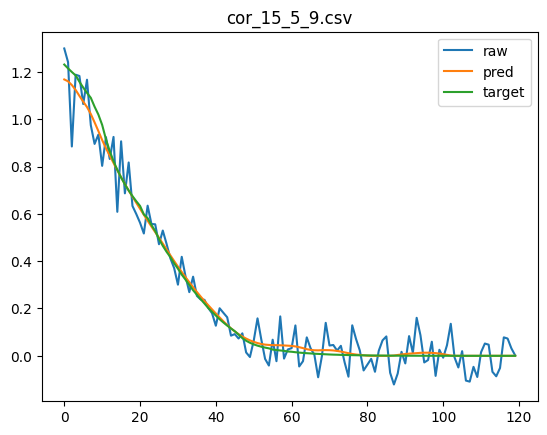

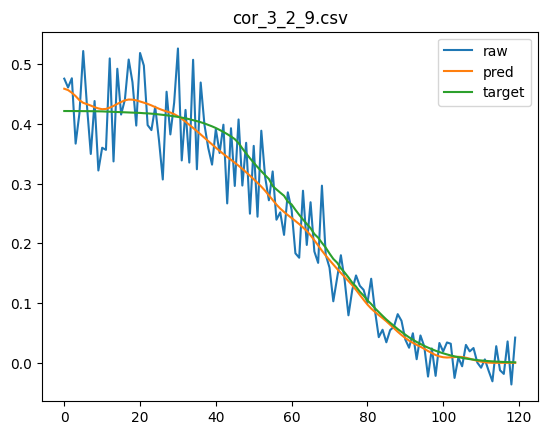

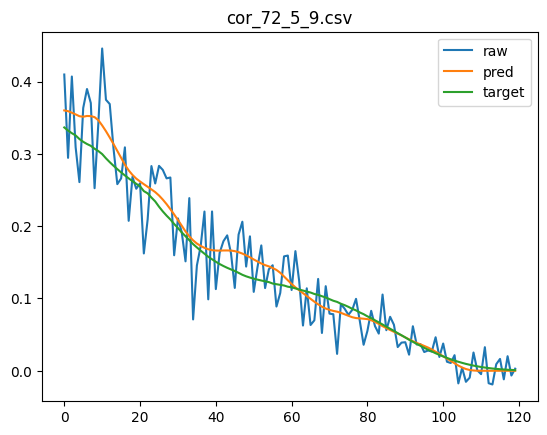

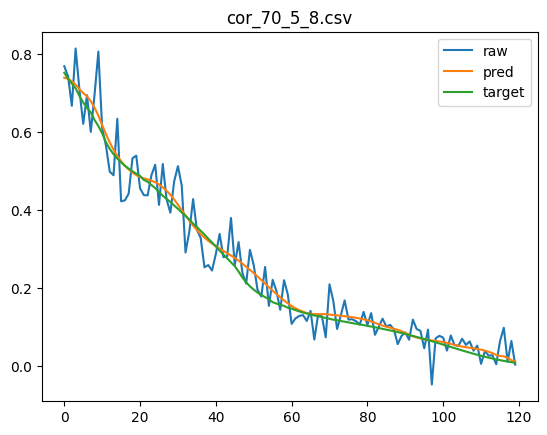

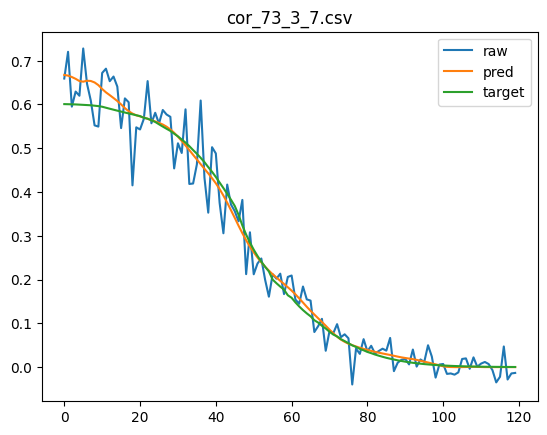

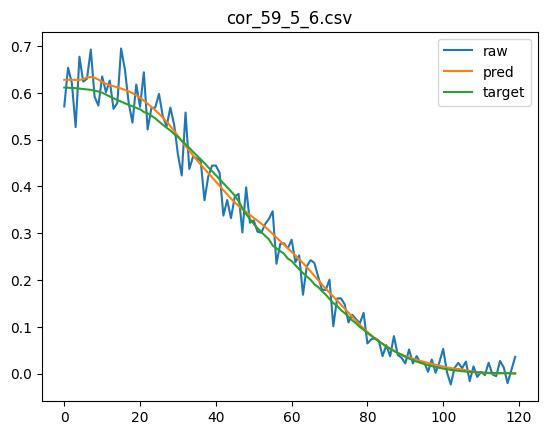

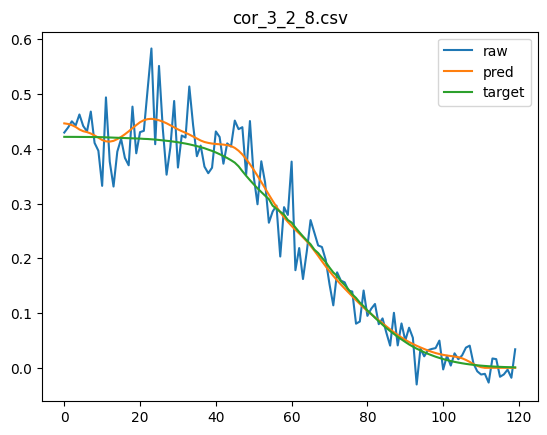

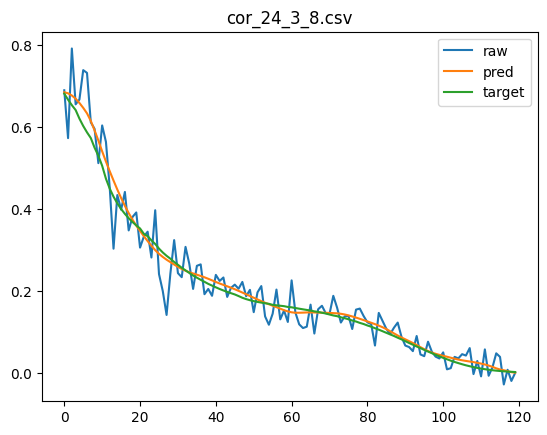

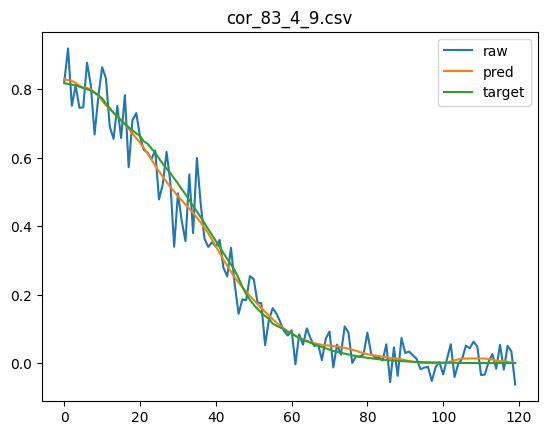

In [708]:
for path in analyse_df.sort_values(by='MAE', ascending=False).head(12).index:
    raw = pd.read_csv(os.path.join('data', path), header=None)[0].tolist()
    target = valid_target_results[valid_target_results.index == path].to_numpy()
    pred = valid_results[valid_results.index == path].to_numpy()
    plt.plot(raw, label='raw')
    plt.plot(pred[0], label='pred')
    plt.plot(target[0], label='target')
    plt.legend()
    plt.title(path)
    plt.show()

Conluision:
- high spred noise makes model to produce more elastic curve according to target one
- as high noise can be considered as big outliers, use MAE or RMAE as training metrics, can imporve performance on highly noise cases
- some more preprocessing steps before training like soft smoothing to remove such peaks in signals can imporove performance of model